# Proces Hawkes'a
## Przetwarzanie danych złożonych: lista 1
### *Patryk Rygiel, 250080*

In [ ]:
library(evently)
library(repr)
library(dplyr)
library(parsedate)

set.seed(13)

## 1. Wczytywanie danych

Jako dane w tym zadaniu używany będzie zbiór "High-energy physics citation network" (http://snap.stanford.edu/data/cit-HepPh.html?fbclid=IwAR0G1rRbyQwNP0scHzzY69m5tFGTvPZbWstlZYX9gIg7KIyoN5a9ktshu5g). Jest to zbiór zawierający graf cytowań pomiędzy pracami naukowymi z fizyki z lat 1993-2003. 

Plik `Cit-HepPh.txt` zawiera skierowany graf połączeń przedstawiający, która praca cytuje którą, natomiast plik `cit-HepPh-dates.txt1` zawiera daty publikacji dla każdej pracy naukowej. 

Jako kaskadę będziemy traktować cytacje jednej wybranej pracy naukowej w czasie, jako wartości magnitude zostaną wybrane ilości cytowań jakie mają prace cytujące.

In [3]:
graph <- read.table("Cit-HepPh.txt", sep='\t', col.names=c("src", "dst"))
data <- read.table("cit-HepPh-dates.txt", sep='\t', col.names=c("id", "time"))

data$time <- sapply(data$time, function(x) as.Date(x, format = "%Y-%m-%d"))

In [4]:
head(graph)

,src,dst
,<int>,<int>
1,9907233,9301253
2,9907233,9504304
3,9907233,9505235
4,9907233,9506257
5,9907233,9606402
6,9907233,9607354


In [5]:
head(data)

,id,time
,<int>,<dbl>
1,9203201,8089
2,9203202,8102
3,9203203,8097
4,9203204,8103
5,9203205,8103
6,9203206,8103


## 2. Procesowanie danych

Tworzenie kolumny "ilość cytacji", która będzie służyć jako magnitude w procesie Hawkes'a

In [6]:
data$citations <- sapply(data$id, function(x) length(which(graph$dst==x)))
head(data)

,id,time,citations
,<int>,<dbl>,<int>
1,9203201,8089,82
2,9203202,8102,3
3,9203203,8097,217
4,9203204,8103,0
5,9203205,8103,0
6,9203206,8103,60


Wybranie artykułów o największej ilości cytacji - jako przykłady do wydobycia kaskad dla procesu Hawkes'a

In [7]:
data <- data[order(-data$citations),]
head(data)

,id,time,citations
,<int>,<dbl>,<int>
18151,9803315,10296,846
18612,9804398,10340,616
4334,9407339,8966,557
9092,9512380,9479,550
10831,9606399,9668,542
19688,9807344,10419,503


Wydobycie dwóch kaskad: artykuł z największą ilością cytacji, artykuł na 200 miejscu w ilości cytacji

In [8]:
extract_cascade <- function(src, data, graph) {
    dsts <- graph[graph$dst == src$id,]$src
    cascade <- data[data$id %in% dsts,]
    cascade <- cascade[order(cascade$time),]
    cascade <- rename(cascade, magnitude="citations")
    return(cascade)
}

In [60]:
cascade_1 <- extract_cascade(data[1,], data, graph)
cascade_2 <- extract_cascade(data[20,], data, graph)

In [61]:
head(cascade_1)

,id,time,magnitude
,<int>,<dbl>,<int>
18302,9803466,10311,305
18612,9804398,10340,616
18761,9805217,10350,100
19015,9805471,10372,79
19144,9806223,10379,16
19184,9806263,10381,110


## 3. Modelowanie

### 2.1 Kaskada dla artykułu:  
#### `The Hierarchy Problem and New Dimensions at a Millimeter` (https://arxiv.org/abs/hep-ph/9803315)

In [11]:
cascade_1$time <- cascade_1$time - min(cascade_1$time)
lasttime_1 <- max(cascade_1$time)

In [49]:
# Długość kaskady 669
cascade_1_train <- cascade_1[1:500,]

In [50]:
model_1 <- fit_series(cascade_1_train, model_type='mEXP', observation_time=lasttime_1, cores=6)
model_1

- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 3.56e+00; beta 6.96e-01; theta 2.61e-01
- par:
  K 8.73e-01; beta 8.85e-02; theta 4.55e-02
- Neg Log Likelihood: 880.182 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 

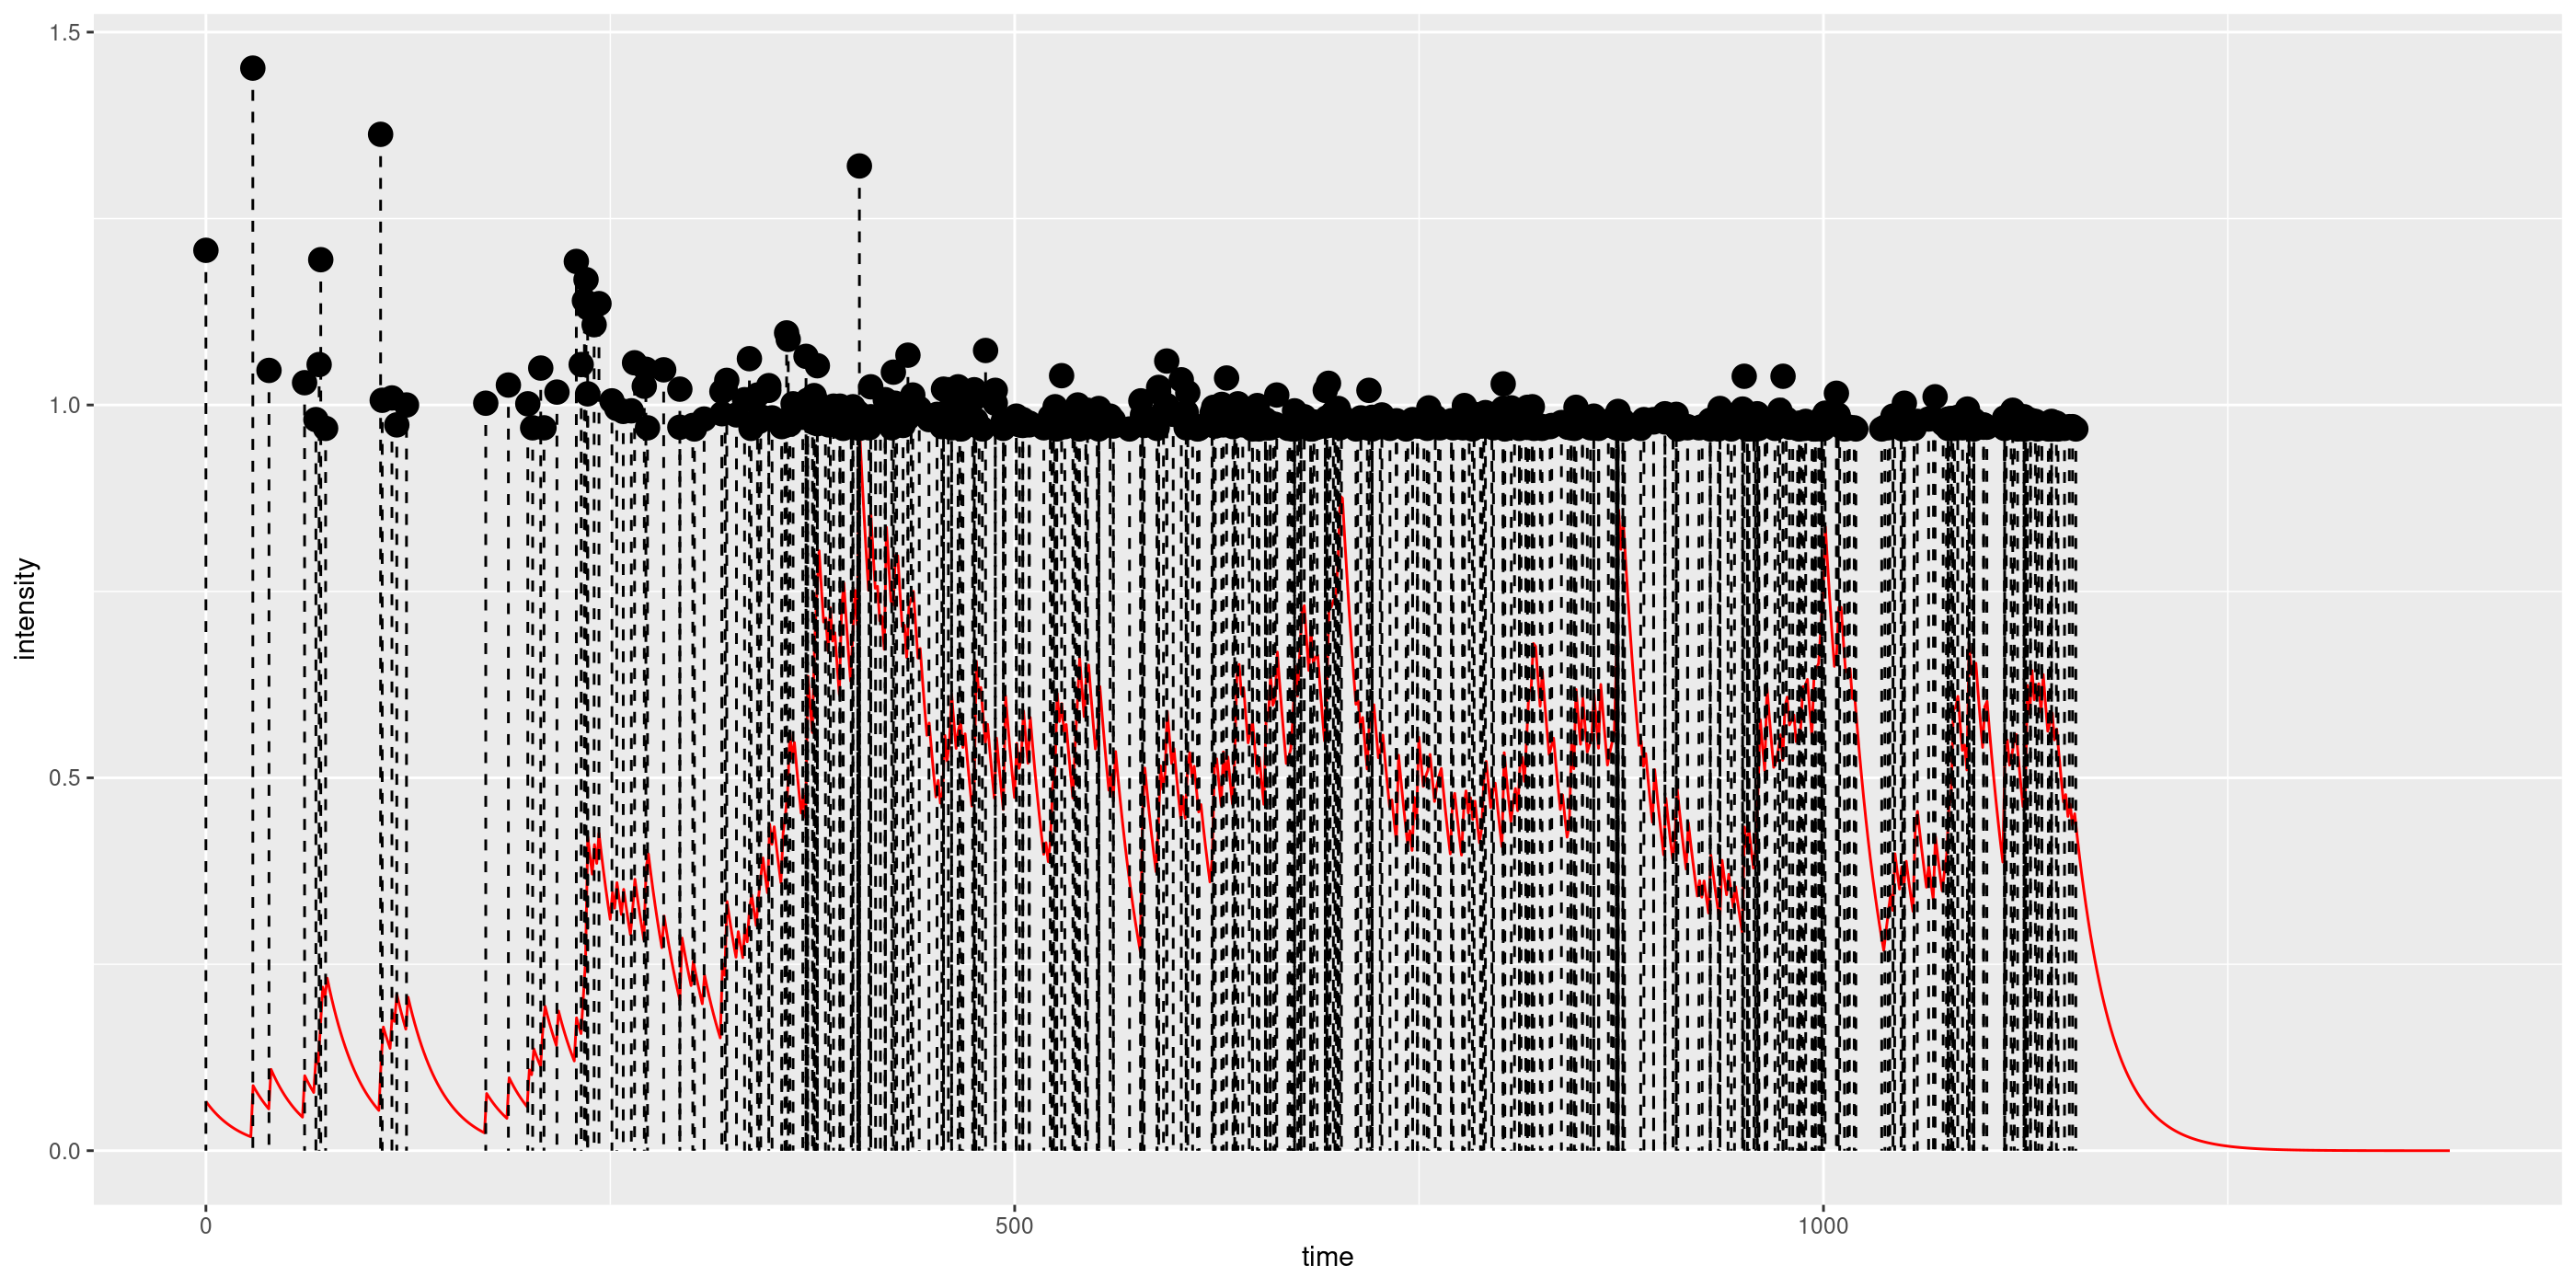

In [51]:
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 200)
plot_event_series(model_1)

In [52]:
get_branching_factor(model_1)

[1] 0.9566523

In [53]:
predict_final_popularity(model_1)

[1] 500.0005

Wybrana kaskada ma branching factor < 1, zatem możliwe jest oszacowanie końcowej popularności - oszacowanie jest bardzo bliskie ilości zdarzeń w zbiorze treningowym ale nie koniecznie blisko rzeczywistej ilości zdarzeń.

Obserwując wykres kaskady widoczny jest start o małej częstotliwości zdarzeń o dużej intensywności oraz późniejsze duże zagęszczenie punktów. Możemy to interpretować  w taki sposób, że najbardziej cytowany artykuł z początku był mało cytowany, bo nie był bardzo znany i było mało prac w temacie, lecz z czasem nabrał on dużego znaczenia naukowego. Branching factor lekko poniżej 1 sugeruje, że funkcja intensywności lekko spada.

### 2.2 Kaskada dla artykułu:
#### `Physics with e^+e^- Linear Colliders` (https://arxiv.org/abs/hep-ph/9705442)

In [62]:
cascade_2$time <- cascade_2$time - min(cascade_2$time)
lasttime_2 <- max(cascade_2$time)

In [64]:
# Długość kaskady 288
cascade_2_train <- cascade_2[1:200,]

In [65]:
model_2 <- fit_series(cascade_2_train, model_type='mEXP', observation_time=lasttime_2, cores=6)
model_2

- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 6.50e+00; beta 4.55e-01; theta 2.72e+00
- par:
  K 9.50e-01; beta 5.11e-02; theta 3.11e-02
- Neg Log Likelihood: 539.185 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 

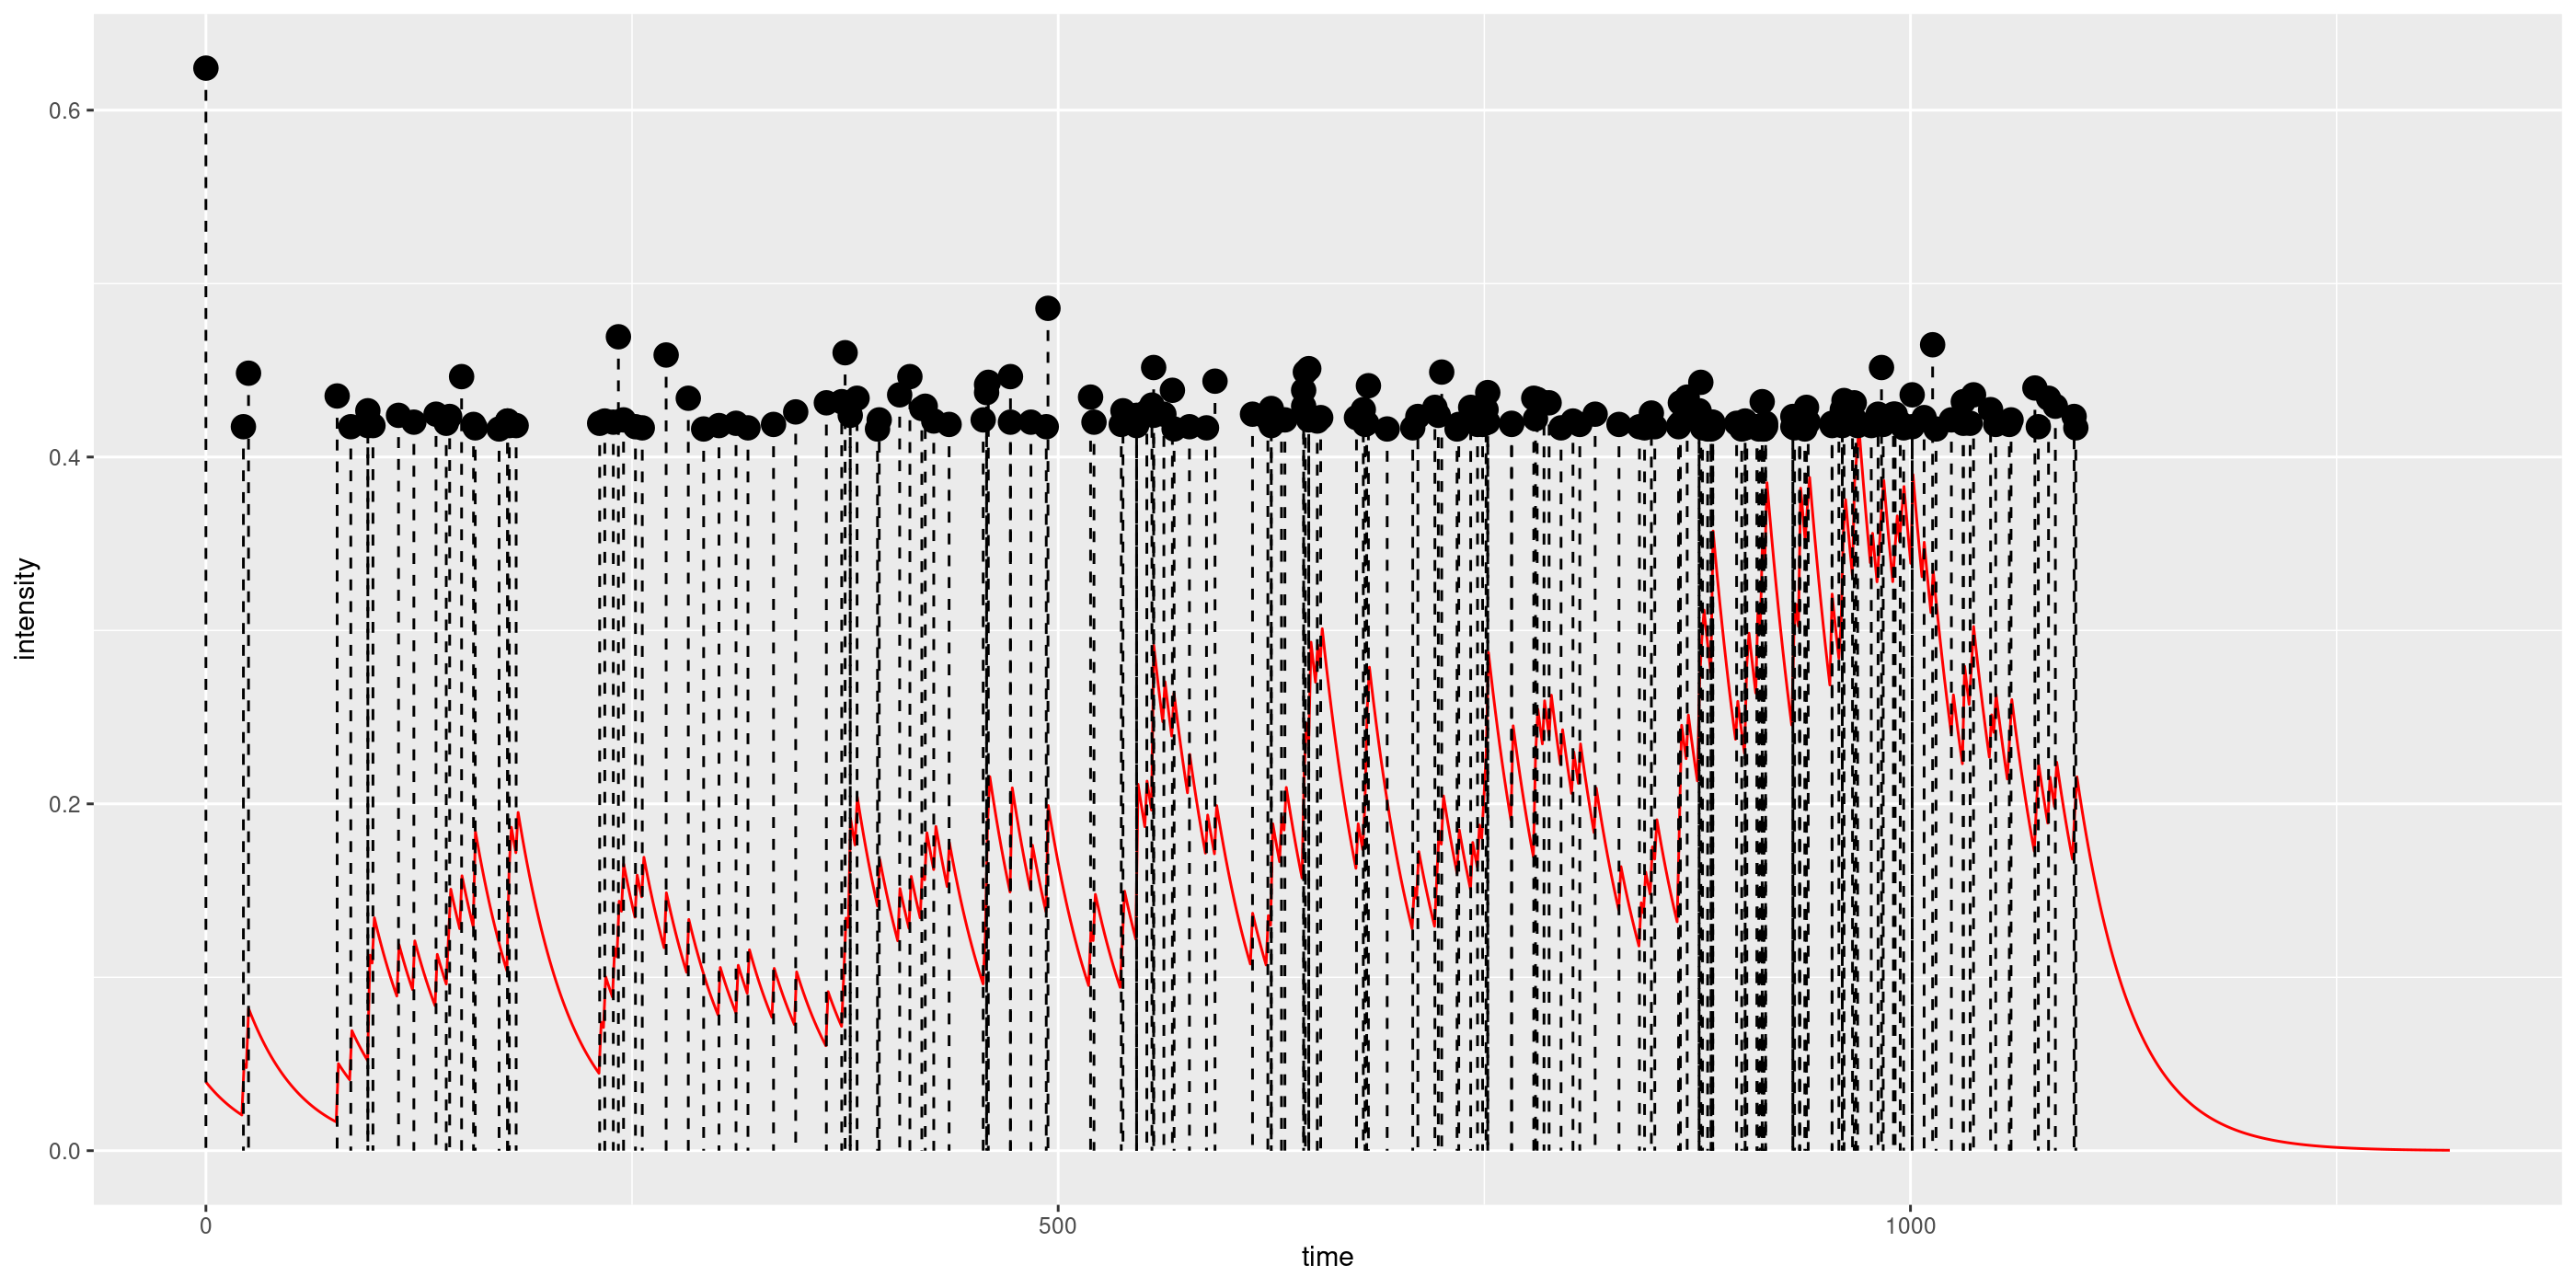

In [66]:
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 200)
plot_event_series(model_2)

In [67]:
get_branching_factor(model_2)

[1] 1

In [68]:
predict_final_popularity(model_2)

Warning message in predict_final_popularity.hawkes(model_2):
“Branching Factor greater than 1, not possible to predict the size(super critical)”


[1] Inf

Dla drugiej wybranej kaskady (20-ty najbardziej popularny artykuł) zauważamy branching factor > 1 co nie pozwala oszacować wielkości kaskady. Proces jest w reżimie superkrytycznym - funkcja intensywności jest rosnąca.

Taką sytuację możemy interpretować tak, że popularność artykułu wzrasta i trudno jest określić jaka będzie jego popularność z czasem.